# Preprocessing, data exploration and model

Necessary imports

In [1]:
import numpy as np
import nltk
import json
import matplotlib.pyplot as plt
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec

In [2]:
with open('mortaldict.json', 'r') as f:
    mortaldict = json.load(f)
    
with open('goddict.json', 'r') as f:
    goddict = json.load(f)

## Preprocessing

First, let's check what the encoding is of the text file, so that we can properly import the texts

In [3]:
with open('text_file.txt') as f:
    print(f)

<_io.TextIOWrapper name='text_file.txt' mode='r' encoding='cp1252'>


As can be seen above, this file doesn't use the standard utf-8 encoding, but cp1252 encoding. So, we will use this encoder when reading it in:

In [4]:
with open("text_file.txt","r",encoding= 'cp1252') as f:
    data = f.readlines()
    
print(data[700])

[313] “So do not thou, my friend, wander long far from home, leaving thy wealth behind thee and men in thy house so insolent, lest they divide and devour all thy wealth, and thou shalt have gone on a fruitless journey. But to Menelaus I bid and command thee to go, for he has but lately come from a strange land, from a folk whence no one would hope in his heart to return, whom the storms had once driven astray into a sea so great, whence the very birds do not fare in the space of a year, so great is it and terrible. But now go thy way with thy ship and thy comrades, or, if thou wilt go by land, here are chariot and horses at hand for thee, and here at thy service are my sons, who will be thy guides to goodly Lacedaemon, where lives fair-haired Menelaus. And do thou beseech him thyself that he may tell thee the very truth. A lie will be not utter, for he is wise indeed.”



We split the data into sentences

In [5]:
sentences = []
for par in data:
    if par == '\n':
        continue
    senttemp = sent_tokenize(par)
    sentences = sentences +senttemp

print(sentences[100:105])

['Howbeit Poseidon had gone among the far-off Ethiopians—the Ethiopians who dwell sundered in twain, the farthermost of men, some where Hyperion sets and some where he rises, there to receive a hecatomb of bulls and rams, and there he was taking his joy, sitting at the feast; but the other gods were gathered together in the halls of Olympian Zeus.', "[28] Among them the father of gods and men was first to speak, for in his heart he thought of noble Aegisthus, whom far-famed Orestes, Agamemnon's son, had slain.", 'Thinking on him he spoke among the immortals, and said: “Look you now, how ready mortals are to blame the gods.', 'It is from us, they say, that evils come, but they even of themselves, through their own blind folly, have sorrows beyond that which is ordained.', 'Even as now Aegisthus, beyond that which was ordained, took to himself the wedded wife of the son of Atreus, and slew him on his return, though well he knew of sheer destruction, seeing that we spake to him before, se

Now, we tokenize the sentences. If the sentence consists of two words or less, we remove it since it won't contain much useful information. Also, this way we might be able to filter out as many chapter titles as possible.

In [39]:
words = []
for sent in sentences:
    wordstemp = word_tokenize(sent)
    if len(wordstemp) <= 2:
        continue
    words.append(wordstemp)
    
print(words[1000])

['If', 'thou', 'couldst', 'in', 'any', 'wise', 'lie', 'in', 'wait', 'and', 'catch', 'him', ',', 'he', 'will', 'tell', 'thee', 'thy', 'way', 'and', 'the', 'measure', 'of', 'thy', 'path', ',', 'and', 'of', 'thy', 'return', ',', 'how', 'thou', 'mayest', 'go', 'over', 'the', 'teeming', 'deep', '.']


Now, we PoS tag the data, so that lemmatization is easier, and names of characters can be identified more easily

In [7]:
tagged = []
for sent in words:
    senttagged = nltk.pos_tag(sent)
    tagged.append(senttagged)

tagged_filtered = []
for sent in tagged:
    sentls = []
    for wordtag in sent:
        if wordtag[1] in ['.', ',', ':', '--', '$', '(', ')'] or wordtag[0] in ['“', '”', '<', '>']:
            continue
        else: sentls.append(wordtag)
    tagged_filtered.append(sentls)
        
print(tagged_filtered[3000:3010])

[[('Thence', 'NN'), ('we', 'PRP'), ('sailed', 'VBD'), ('on', 'IN'), ('grieved', 'VBN'), ('at', 'IN'), ('heart', 'NN'), ('glad', 'NN'), ('to', 'TO'), ('have', 'VB'), ('escaped', 'VBN'), ('death', 'NN'), ('though', 'IN'), ('we', 'PRP'), ('had', 'VBD'), ('lost', 'VBN'), ('our', 'PRP$'), ('dear', 'JJ'), ('comrades', 'NNS')], [('SEARCH', 'NNP'), ('THEOI', 'NNP')], [('CLASSICAL', 'NNP'), ('TEXTS', 'NNP'), ('LIBRARY', 'NNP')], [('Aeschylus', 'NNP'), ('Agamemnon', 'NNP')], [('Aeschylus', 'NNP'), ('Eumenides', 'NNP')], [('Aeschylus', 'NNP'), ('Libation', 'NNP'), ('Bearers', 'NNP')], [('Aeschylus', 'NNP'), ('Prometheus', 'NNP'), ('Bound', 'NNP')], [('Aeschylus', 'NNP'), ('Seven', 'NNP'), ('Against', 'NNP'), ('Thebes', 'NNP')], [('Aeschylus', 'NNP'), ('Suppliant', 'NNP'), ('Women', 'NNP')], [('Aeschylus', 'NNP'), ('Fragments', 'NNS')]]


Next, we lemmatize the dataset

In [8]:
# Reference for lemmatizing: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python

lemmatizer = WordNetLemmatizer()

lemmatized = []
for sent in tagged_filtered:
    
    sentls = []
    for wordtag in sent:
        tag = ''
        if wordtag[1][0:2] ==  'NN':
            tag =  'n'
        elif wordtag[1][0:2] ==  'VB':
            tag =  'v'
        elif wordtag[1][0:2] ==  'JJ':
            tag =  'a'
        elif wordtag[1][0:2] ==  'RB':
            tag =  'r'
        
        # use postag if it exists in the wordnetlemmatizer
        if tag == '': lemma = lemmatizer.lemmatize(wordtag[0])
        else: lemma = lemmatizer.lemmatize(wordtag[0], pos=tag)
        
        sentls.append([lemma, wordtag[1]])
    lemmatized.append(sentls)
    
print(lemmatized[3000:3010])

[[['Thence', 'NN'], ['we', 'PRP'], ['sail', 'VBD'], ['on', 'IN'], ['grieve', 'VBN'], ['at', 'IN'], ['heart', 'NN'], ['glad', 'NN'], ['to', 'TO'], ['have', 'VB'], ['escape', 'VBN'], ['death', 'NN'], ['though', 'IN'], ['we', 'PRP'], ['have', 'VBD'], ['lose', 'VBN'], ['our', 'PRP$'], ['dear', 'JJ'], ['comrade', 'NNS']], [['SEARCH', 'NNP'], ['THEOI', 'NNP']], [['CLASSICAL', 'NNP'], ['TEXTS', 'NNP'], ['LIBRARY', 'NNP']], [['Aeschylus', 'NNP'], ['Agamemnon', 'NNP']], [['Aeschylus', 'NNP'], ['Eumenides', 'NNP']], [['Aeschylus', 'NNP'], ['Libation', 'NNP'], ['Bearers', 'NNP']], [['Aeschylus', 'NNP'], ['Prometheus', 'NNP'], ['Bound', 'NNP']], [['Aeschylus', 'NNP'], ['Seven', 'NNP'], ['Against', 'NNP'], ['Thebes', 'NNP']], [['Aeschylus', 'NNP'], ['Suppliant', 'NNP'], ['Women', 'NNP']], [['Aeschylus', 'NNP'], ['Fragments', 'NNS']]]


Next, we go through the data and print all the proper nouns that aren't in the dictionaries. If they are not and they refer to names of characters that are either Olympian gods or mortals, we add them to the dictionaries in the file characterdicts.ipynb. We do this only for names that occur at least 10 times in the book, since adding all names is not realistic. The below code prints the proper nouns (or words that were classified as such) that we didn't add to the dictionary. As can be seen, all of these are either not names, names of people who aren't part of mythology, or children of gods (in which case we left them out, since they are somewhere between god and mortal).

In [9]:
# Reference for sorting dictionary: https://www.edureka.co/blog/sort-dictionary-by-value-in-python/

non_occuring = {}
non_occuring_min10 = {}

mortals = mortaldict
gods = goddict

for sent in lemmatized:
    for wordtag in sent:
    
        # Only look at proper nouns
        if wordtag[1] == 'NNP':

            # Binary to indicate if the word has been found
            filled_in = 0

            # Go through mortaldict
            for idx, vals in enumerate(mortals.values()):
                if wordtag[0] in vals[0]:
                    filled_in = 1
                    break

            # If word hasn't been found in mortaldict, go through goddict
            if filled_in == 0:
                for idx, vals in enumerate(gods.values()):
                    if wordtag[0] in vals[0]:
                        filled_in = 1
                        break

            # Print word if it hasn't been found at all
            if filled_in == 0:
                if wordtag[0] in non_occuring.keys():
                    non_occuring[wordtag[0]] += 1
                else: non_occuring[wordtag[0]] = 1

for key in non_occuring.keys():
    if non_occuring[key] >= 10:
        non_occuring_min10[key] = non_occuring[key]

for key in sorted(non_occuring_min10.keys()):
       print("%s: %s" % (key, non_occuring_min10[key]))

A: 135
A-Z: 65
A.: 67
ARTICLES: 65
Aaron: 65
Achaea: 40
Achaean: 55
Achaeans: 26
Achilleid: 65
Aeacus: 67
Aeneid: 65
Aeolus: 10
Aeschylus: 455
Against: 67
Ah: 67
Aiantes: 18
Alcman: 65
Alexander: 49
Alexandra: 65
Amazon: 20
Amazons: 13
Antenor: 31
Antinous: 57
Apollodorus: 65
Apollonius: 65
Aratus: 65
Argive: 70
Argives: 121
Argonautica: 130
Argos: 54
Armour: 25
Asius: 20
Astronomica: 65
Atsma: 65
Ay: 17
Aye: 64
BOOK: 1540
BY: 65
Barring: 25
Battle: 51
Be: 17
Bearers: 65
Beggar: 50
Beguiling: 25
Bion: 65
Body: 25
Book: 65
Bound: 65
CLASSICAL: 65
CONTENTS: 65
Callimachus: 65
Callistratus: 65
Calypso: 50
Child: 14
Chiliades: 65
Chryse: 10
Chryses: 10
Circe: 70
Classical: 71
Colluthus: 65
Come: 62
Contact: 65
Contest: 65
Copyright: 65
Crete: 21
Cretensis: 65
Cronos: 161
Cycle: 67
Cyclopes: 12
Cyclops: 47
Danaan: 41
Dardanus: 22
Dawn: 78
Days: 65
Dead: 90
Dear: 15
Description: 65
Descriptions: 65
Dialogues: 130
Dictys: 65
Diodorus: 65
Dionysiaca: 65
Dolon: 10
Doom: 18
Dost: 11
Duel: 50
Dul

## Data exploration

First, we go through the texts, and count how many times a certain name is mentioned.

In [10]:
i = 0
for idx, sent in enumerate(lemmatized):
    for idx2, wordtag in enumerate(sent):
        word = wordtag[0]
        tag = wordtag[1]

        if tag == 'NNP':

            # Binary to indicate if the word has been found
            filled_in = 0

            # Go through mortaldict
            for idx3, vals in enumerate(mortaldict.values()):
                if word in vals[0]:
                    filled_in = 1
                    mortaldict[str(idx3)][1] += 1
                    lemmatized[idx][idx2][1] = 'NNPm'
                    i += 1
                    break

            # If word hasn't been found in mortaldict, go through goddict
            if filled_in == 0:
                for idx4, vals in enumerate(goddict.values()):
                    if word in vals[0]:
                        filled_in = 1
                        goddict[str(idx4)][1] += 1
                        lemmatized[idx][idx2][1] = 'NNPg'
                        i += 1
                        break

Below we print the amounts of times mortals and gods are mentioned. Note that in reality this number is a bit higher because we are not looking at all mortals and all gods. While mortals are named more often, both gods and mortals are named enough times to be able to do a meaningful analysis.

In [11]:
summortals = 0
sumgods = 0

for mval in mortaldict.values():
    summortals += mval[1]
    
for gval in goddict.values():
    sumgods += gval[1]
    
print('Total amount of mortal names: ', summortals)
print('Total amount of god names: ', sumgods)

Total amount of mortal names:  7846
Total amount of god names:  3145


Next, we plot the 20 most common names for both mortals and gods. 

In [12]:
# Reference for sorting dict: https://www.geeksforgeeks.org/python-sort-list-according-second-element-sublist/

sortm = list(mortaldict.values())
sortm.sort(key = lambda x: x[1])
sortm.reverse()

sortg = list(goddict.values())
sortg.sort(key = lambda x: x[1])
sortg.reverse()

In [13]:
mnames = [name[0][0] for name in sortm]
mcounts = [count[1] for count in sortm]

gnames = [name[0][0] for name in sortg]
gcounts = [count[1] for count in sortg]

As can be seen in the graphs, the most common names make sense considering the original texts. The main characters of for example the Iliad and Odyssee occur most often, and the most important gods are named the most.

Text(0.5, 1.0, '20 most common mortals and their frequencies')

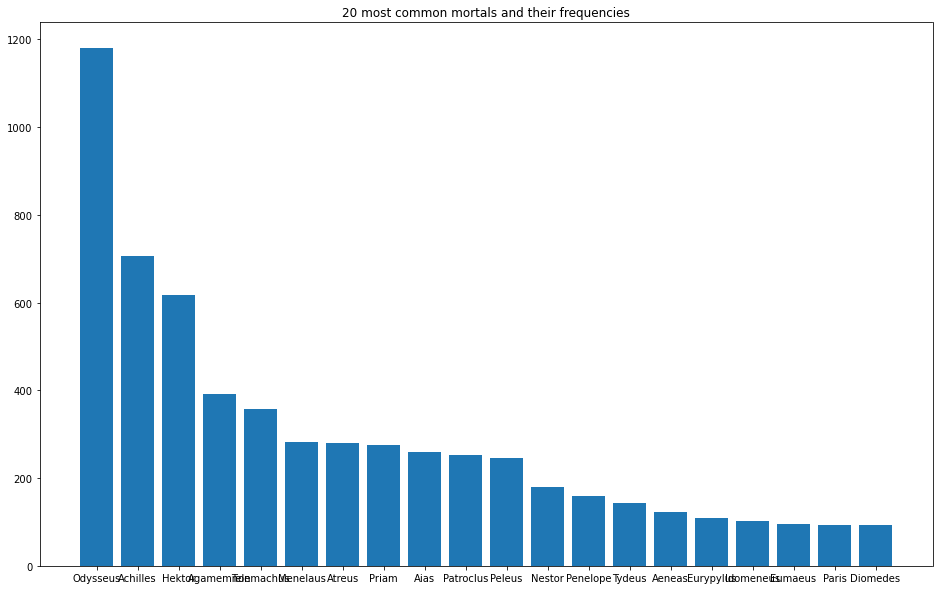

In [14]:
plt.figure(figsize=(16, 10))
plt.bar(mnames[0:20], mcounts[0:20])
plt.title('20 most common mortals and their frequencies')

Text(0.5, 1.0, '20 most common gods and their frequencies')

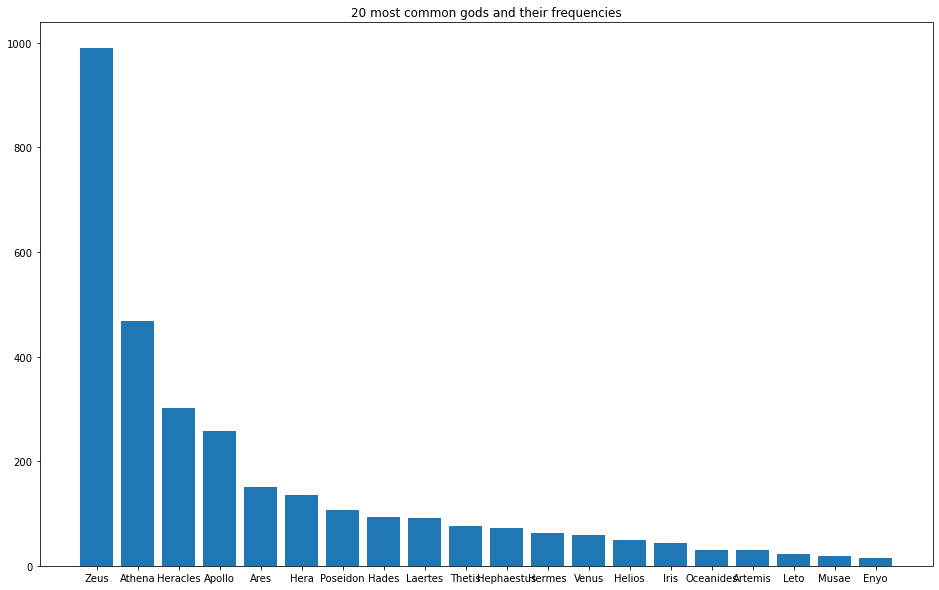

In [15]:
plt.figure(figsize=(16, 10))
plt.bar(gnames[0:20], gcounts[0:20])
plt.title('20 most common gods and their frequencies')

Next, we take the context of each name.

In [46]:
name_cons = []
for idx, sent in enumerate(lemmatized):
    for idx2, wordtag in enumerate(sent):    
        word = wordtag[0]
        tag = wordtag[1]

        if tag == 'NNPm' or tag == 'NNPg':
            context = sent[max(0, idx2-5):idx2] + sent[idx2+1: min(len(sent), idx2+5)]
            name_cons.append([wordtag, context])

print(name_cons[100])

[['Penelope', 'NNPm'], [['the', 'DT'], ['daughter', 'NN'], ['of', 'IN'], ['Icarius', 'NNPm'], ['wise', 'NN'], ['hear', 'VBD'], ['his', 'PRP$'], ['wondrous', 'JJ'], ['song', 'NN']]]


We check whether there are enough adjectives and adverbs in the context of the names to be able to perform the analysis. 

In [47]:
advcountm = 0
adjcountm = 0
advcountg = 0
adjcountg = 0

for namecon in name_cons:
    name = namecon[0]
    con = namecon[1]
    
    if name[1] == 'NNPm':
        for wordtag in con:
            if wordtag[1][0:2] == 'RB':
                advcountm += 1
            elif wordtag[1][0:2] == 'JJ':
                adjcountm += 1
                
    elif name[1] == 'NNPg':
        for wordtag in con:
            if wordtag[1][0:2] == 'RB':
                advcountg += 1
            elif wordtag[1][0:2] == 'JJ':
                adjcountg += 1
                
print('There are ', advcountm, ' adverbs, and ', adjcountm, ' adjectives around names of mortals.')
print('There are ', advcountg, ' adverbs, and ', adjcountg, ' adjectives around names of gods.')

There are  3538  adverbs, and  3624  adjectives around names of mortals.
There are  1276  adverbs, and  1548  adjectives around names of gods.


We consider these as enough adjectives and adverbs to perform the analysis. We'll save the contexts so that they can be used in the model (we focused on Word2Vec first, we will use these context for the analysis after that).

## Model

First, we will implement the Word2Vec model to see whether words around mortals are different from those around gods. Lemmatized_replace is a list of the PoS tagged data, where each name of a mortal or god is replaced by MORTALNAME or GODNAME. This way, we can clearly see the difference between gods and mortals, without having to go through all names of gods and mortals and seeing what words are most similar to them. 

In [36]:
lemmatized_replace = []

for sent in lemmatized:
    sentls = []
    for wordtag in sent:
        if wordtag[1] == 'NNPm': 
            sentls.append(['MORTALNAME', 'NNPm'])
        elif wordtag[1] == 'NNPg':
            sentls.append(['GODNAME', 'NNPg'])
        else: sentls.append(wordtag)
    lemmatized_replace.append(sentls)

print(lemmatized_replace[100])

[['Howbeit', 'NNP'], ['GODNAME', 'NNPg'], ['have', 'VBD'], ['go', 'VBN'], ['among', 'IN'], ['the', 'DT'], ['far-off', 'NN'], ['Ethiopians—the', 'NNP'], ['Ethiopians', 'NNPS'], ['who', 'WP'], ['dwell', 'VBP'], ['sunder', 'VBN'], ['in', 'IN'], ['twain', 'NN'], ['the', 'DT'], ['farthermost', 'NN'], ['of', 'IN'], ['men', 'NNS'], ['some', 'DT'], ['where', 'WRB'], ['Hyperion', 'NNP'], ['set', 'NNS'], ['and', 'CC'], ['some', 'DT'], ['where', 'WRB'], ['he', 'PRP'], ['rise', 'VBZ'], ['there', 'EX'], ['to', 'TO'], ['receive', 'VB'], ['a', 'DT'], ['hecatomb', 'NN'], ['of', 'IN'], ['bull', 'NNS'], ['and', 'CC'], ['ram', 'NNS'], ['and', 'CC'], ['there', 'RB'], ['he', 'PRP'], ['be', 'VBD'], ['take', 'VBG'], ['his', 'PRP$'], ['joy', 'NN'], ['sit', 'VBG'], ['at', 'IN'], ['the', 'DT'], ['feast', 'NN'], ['but', 'CC'], ['the', 'DT'], ['other', 'JJ'], ['god', 'NNS'], ['be', 'VBD'], ['gather', 'VBN'], ['together', 'RB'], ['in', 'IN'], ['the', 'DT'], ['hall', 'NNS'], ['of', 'IN'], ['Olympian', 'JJ'], ['GODN

Below, we made two lists that can be used in the model. One contains all names adverbs, and adjectives. The other contains all words. We were debating which one to use in the model, which is why for now we kept both in. Right now, we are using all words as input for the model. This is because if we filter out all words except adverbs and adjectives, the windows around the target words overlap much, resulting in almost identical similarity scores for mortals and gods. We will most likely filter out all the adjectives and adverbs after retrieving the words with the highest similarity scores, so that the filtering has less of an effect on the model.

In [19]:
advadjfilt = []
nofilt = []
for sent in lemmatized_replace:
    sentls = []
    sentlsfilt = []
    for word in sent:
        sentls.append(word[0])
        if word[1][0:2] in ['RB', 'JJ'] or word[1] in ['NNPg', 'NNPm']:
            sentlsfilt.append(word[0])
    advadjfilt.append(sentlsfilt)
    nofilt.append(sentls)

The parameters below were mostly taken from the notebook from week 5. We lowered the min_count, since we also want rare adjectives and adverbs to be taken into account. We also upped the amount of epochs, to prevent underfitting. However, we also did not make this number as large, because overfitting should also be prevented. 

In [20]:
params = {
    'vector_size': 100, # dimension of embeddings
    'window': 4, # window -/+ before and after focus word
    'epochs': 10, # number of iterations over the corpus
    'min_count': 2, # filter on words whose frequency is below this count
    'sg': 0, # use the skip-gram (1) or the CBOW (0) mode. In class, we presented the CBOW (predict context given focus words). See optional materials for the skip-gram (predict focus given context)
    'negative': 5, # how many negative samples to use (see optional class contents too)
    'workers': 4, # how many cores to use
    'alpha': 0.05 # initial learning rate for SGD. This is lambda in the class notes
}
model = Word2Vec(nofilt, **params)

As can be seen below, the words that are most similar to gods are different from those that are most similar to mortals, but they contain many names and words that are not adjectives or adverbs. We now make lists with specifically the most similar adverbs and adjectives to gods and mortals.

In [21]:
for word in list(model.wv.most_similar('GODNAME', topn=20)):
    print(word)

('Circe', 0.5733983516693115)
('Shaker', 0.5726999044418335)
('Earth', 0.5722328424453735)
('beareth', 0.5696876049041748)
('aegis', 0.546894371509552)
('goddess', 0.5447436571121216)
('Cronos', 0.5345305800437927)
('loud-thundering', 0.5296200513839722)
('archer', 0.490050733089447)
('Ares', 0.48496535420417786)
('Thetis', 0.47644516825675964)
('Olympian', 0.45839405059814453)
('flashing-eyed', 0.4575539529323578)
('daughter', 0.4502430558204651)
('Father', 0.4413818418979645)
('god', 0.4358479976654053)
('nymph', 0.42988690733909607)
('Thunderer', 0.4287538528442383)
('Helen', 0.42829659581184387)
('white-armed', 0.41929754614830017)


In [22]:
for word in list(model.wv.most_similar('MORTALNAME', topn=20)):
    print(word)

('Aeacus', 0.5793870091438293)
('prince', 0.5746580958366394)
('Alexander', 0.5198440551757812)
('son', 0.5046851634979248)
('Sarpedon', 0.48815155029296875)
('Antenor', 0.47579601407051086)
('Achilles', 0.4745894968509674)
('hero', 0.4712666869163513)
('squire', 0.4686458706855774)
('Phaeacians', 0.46567007899284363)
('him', 0.4607539474964142)
('Dardanus', 0.4509890377521515)
('valiant', 0.4474540054798126)
('Menoetius', 0.43660613894462585)
('tomb', 0.43628835678100586)
('Glaucus', 0.43492576479911804)
('godlike', 0.4313065707683563)
('Achaeans', 0.42982038855552673)
('spearman', 0.4261559247970581)
('comrade', 0.41927963495254517)


In [29]:
lemmatized_replace_words = []
lemmatized_replace_tags = []

for sent in lemmatized_replace:
    for word in sent:
        lemmatized_replace_words.append(word[0])
        lemmatized_replace_tags.append(word[1])

similarg = []
similarm = []

for word in list(model.wv.most_similar('MORTALNAME', topn=3000)):
    tag = lemmatized_replace_tags[lemmatized_replace_words.index(word[0])]
    if tag[0:2] in ['RB', 'JJ']:
        similarm.append([word[0], word[1]])

for word in list(model.wv.most_similar('GODNAME', topn=3000)):
    tag = lemmatized_replace_tags[lemmatized_replace_words.index(word[0])]
    if tag[0:2] in ['RB', 'JJ']:
        similarg.append([word[0], word[1]])

Below are the lists of the most similar adverbs and adjectives. These lists seem to make sense, since adjectives that are only for gods (like Olympian) are most similar to gods, and the other way around (godlike is much more similar to mortals, which makes sense because a god won't be described as being 'godlike'.

In [34]:
for word in similarg[:20]:
    print(word)
print('\n')
for word in similarm[:20]:
    print(word)

['loud-thundering', 0.5296200513839722]
['Olympian', 0.45839405059814453]
['flashing-eyed', 0.4575539529323578]
['white-armed', 0.41929754614830017]
['borne', 0.3996431231498718]
['afar', 0.394374817609787]
['ox-eyed', 0.3834258019924164]
['sprung', 0.3666868507862091]
['fair-haired', 0.35366037487983704]
['silver-footed', 0.34587210416793823]
['heaven', 0.3426588773727417]
['secretly', 0.3171946108341217]
['fair-tressed', 0.3145049512386322]
['crooked-counselling', 0.3110371232032776]
['golden', 0.3010319471359253]
['aegis-bearing', 0.2994522750377655]
['wolf-born', 0.297989159822464]
['most', 0.29608049988746643]
['baneful', 0.28929412364959717]
['gracious', 0.2804180979728699]


['valiant', 0.4474540054798126]
['godlike', 0.4313065707683563]
['peerless', 0.40374934673309326]
['glorious', 0.378921240568161]
['swift-footed', 0.3714543581008911]
['covetous', 0.3606129586696625]
['great-souled', 0.34280216693878174]
['noble', 0.3284418284893036]
['lordly', 0.32413363456726074]
['dead', 

## rough draft data visualisation

In [31]:
from sklearn.decomposition import PCA
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    # do PCA on the selected embeddings
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

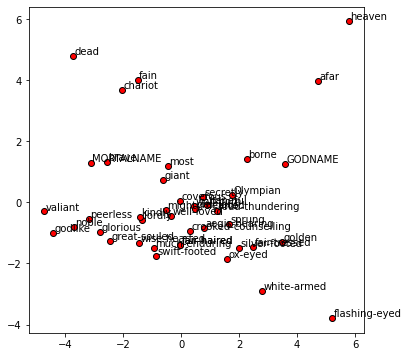

In [32]:
#words taken from most_similar above
display_pca_scatterplot(model.wv, 
                        ['GODNAME', 'MORTALNAME']+[x[0] for x in similarm[:20]]+[x[0] for x in similarg[:20]])

## Word embedding